# 2018/2019 - Task List 1

1. Generate random variable from prefered dystribution using Pyro (pyro.sample)
    
    - animate how distribution of values changes
    - animate histograms of values
    - start with empty list of values, generate new samples, generate histogram
    
    
2. Write a simulator (and exact solution utilizing Bayes theorem) for chances to be ill on a certain disease. We know that it affects from about 1 to 100 out of 50,000 people. There was developed a test to check whether the person has the disease and it is quite accurate: the probability that the test result is positive (suggesting the person has the disease), given that the person does not have the disease, is only 2 percent; the probability that the test result is negative (suggesting the person does not have the disease), given that the person has the disease, is only 1 percent. When a random person gets tested for the disease and the result comes back positive, what is the probability that the person has the disease? Check whole parameter space and visualise results.

    - it must be a simulator!
    - sample from distribution using given probabilities
    - repeate experiment and compare with Bayes equation


## Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

## Generating single value from normal distribution with given mean and variance

In [46]:
mean = 0
variance = 10
x = pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))
print(x)

tensor(-14.6975)


## Sampling from categorical probabilities with given probabilities

In [10]:
x = pyro.sample("categorical_sampling", pyro.distributions.Categorical(logits = torch.tensor([0.5, 0.5])))
print(x)

tensor(1)


## Animating data

/opt/conda/lib/python3.6/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


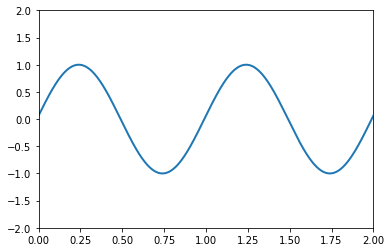

In [30]:
def animate():
    # First set up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots()

    ax.set_xlim(( 0, 2))
    ax.set_ylim((-2, 2))

    line, = ax.plot([], [], lw=2)
    
    # animation function. This is called sequentially
    def sin(i):
        x = np.linspace(0, 2, 1000)
        y = np.sin(2 * np.pi * (x - 0.01 * i))
        line.set_data(x, y)
        return (line,)

    # initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return (line,)
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, sin, init_func=init,
                                   frames=100, interval=20, blit=True)
    return HTML(anim.to_jshtml())

animate()

## Drawing histogram

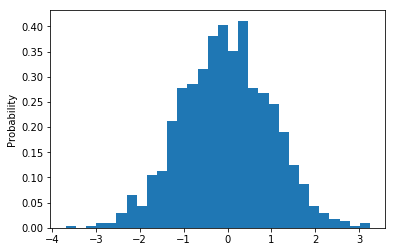

In [2]:
x = np.random.normal(size = 1000)
plt.hist(x, density=True, bins=30)
plt.ylabel('Probability');

## Task 1

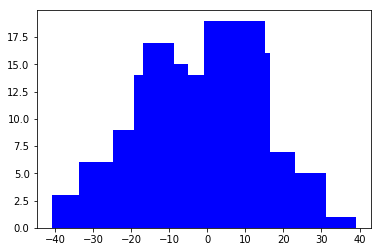

In [104]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML


def animate():
    max_frames = 100
    values = []
    mean= 0
    variance=15
    def get_normal_sampling_next_value():
        x = pyro.sample("normal_sampling", pyro.distributions.Normal(mean, variance))
        return x.item()
    
    def get_poisson_next_value():
        x= pyro.sample("poisson", pyro.distributions.Poisson(5))
        return x
    
    def update_data(num, values):
        nextValue = get_normal_sampling_next_value()
        values.append(nextValue)
        plt.hist(values, color= "blue")
        
    def init():
        plt.hist(values)
        return (plt.hist, )

    fig = plt.figure()

    anim = animation.FuncAnimation(fig, update_data, init_func=init, frames= max_frames, interval=100, fargs=(values, ) )
    return HTML(anim.to_jshtml())

animate()

## Task 2

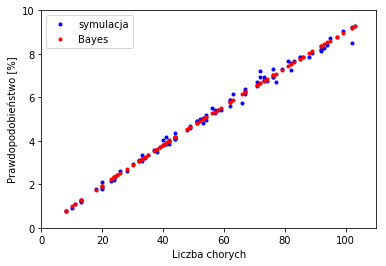

In [110]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

def simulator():
    max_frames = 100
    population_size = 50000
    min_sick_probability = 0.0002
    max_sick_probability = 0.002
    p_positive_when_healthy = 0.02
    p_negative_when_healthy = 0.98
    p_negative_when_sick = 0.01
    p_positive_when_sick = 0.99
    
    sick_quantity =[]
    simulation_probability =[]
    bayes_probability=[]
    
    # wykres
    fig, ax = plt.subplots()
    ax.set_xlim(( 0, 110))
    ax.set_ylim((0, 10))
    plt.xlabel("Liczba chorych")
    plt.ylabel("Prawdopodobieństwo [%]")
    line, = ax.plot([], [], 'bo', label ="symulacja", markersize=3)
    line2, = ax.plot([], [], 'ro', label= "Bayes", markersize=3)    
    ax.legend()
    
    def get_sick_probability():
        return np.random.uniform(min_sick_probability, max_sick_probability)
    
    # chory = 0, zdrowy =1
    def generate_population(sick_probability):
        return np.random.choice((0, 1), size = population_size, p=[sick_probability,1- sick_probability])

    # wynik negatywny = 0 , wynik pozytywny =1
    def test_person(person):
        if person==0:
            result =  pyro.sample("categorical_sampling", pyro.distributions.Categorical(probs = torch.tensor([0.01, 0.99])))
            return result.item(), person
        elif person==1:
            result =  pyro.sample("categorical_sampling", pyro.distributions.Categorical(probs = torch.tensor([0.98, 0.02])))
            return result.item(), person

    # 0 -> p_h, 1-> p_s
    def assigne_test_result_to_category(test_result, categories):   
        if test_result[0]==1 and test_result[1] == 1:
            categories[0] += 1
        elif test_result[0]==1 and test_result[1] == 0:
            categories[1] +=1
        return categories

    def count_sick_when_positive_probability(positive_healthy, positive_sick):
        return 100 * positive_sick  / (positive_healthy + positive_sick)
    
    def bayes_equation(population):
        p_s = count_sick_probability(population)
        return 100 * count_with_bayes_equation(p_s)
    
    def count_with_bayes_equation(sick_probability):
        counter = p_positive_when_sick * sick_probability 
        denominator = (p_positive_when_sick * sick_probability + p_positive_when_healthy * (1-sick_probability))
        return counter/ denominator
    
    def count_sick_quantity(population):
        return population.tolist().count(0)
        
    def count_sick_probability(population):
        sick_quantity = count_sick_quantity(population)
        return  sick_quantity / len (population)
      
    def simulate(i):  
        sick_probability = get_sick_probability()
        population = generate_population(sick_probability)  
        categories = [0, 0]
        index = 0
        while index < population_size:
            test = test_person(population.item(index))
            categories = assigne_test_result_to_category(test, categories)
            index += 1
        simulation_result = count_sick_when_positive_probability(categories[0], categories[1])
        bayes = bayes_equation(population)
        quantity = count_sick_quantity(population)
        
        sick_quantity.append(quantity)
        simulation_probability.append(simulation_result)
        bayes_probability.append(bayes)
        
        line.set_data(sick_quantity, simulation_probability)
        line2.set_data( sick_quantity, bayes_probability)

    def init():
        line.set_data([], [])
        line2.set_data([], [])
        return (line, line2,)
    
    anim = animation.FuncAnimation(fig, simulate, init_func=init, frames=max_frames, interval=100 )
    return HTML(anim.to_jshtml())  

simulator()   
  